## 1. Importing Libraries and Generally Creating Environment

In [1]:
import numpy as np                               
import pandas as pd                              
import matplotlib.pyplot as plt                  
import seaborn as sns  
from scipy import stats
import statsmodels.api as sm
from fbprophet import Prophet
import logging
logging.getLogger().setLevel(logging.ERROR)
import math
import random
import seaborn as sns 

In [2]:
# this is for prediction model that I want to try for myself
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [3]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## 2. Exploratory Data Analysis

### 2.0 Data Examination and Understanding

In [4]:
print('Reading and appending our data....')
df1 = pd.read_csv('Data/2019-Oct.csv', nrows=999999 )
print('Only first part. Still waiting 667...')
df2 = pd.read_csv('Data/2019-Nov.csv', nrows=999999)
df = df1.append(df2)
print('Ready!')

Reading and appending our data....
Only first part. Still waiting 667...
Ready!


In [5]:
df.shape #This is really a lot of data

(1999998, 9)

In [6]:
# This is a code where I tried to extract random 1 % of unique user ids so that there will be less data.
# I did this because the original data is too large and it takes too much time to compute.
# Firstly I applied this logic to user sessions then I understood that one user could have multiple sessions. 
print('Leaving only 10 % of unique users')
u = df['user_id'].unique().tolist()
length = len(u)*0.1
u = random.sample(u, math.floor(length))
df = df[df.user_id.isin(u)]
# Here I tried to achieve my goal by dropping duplicates: took too much time. 
# user_session = df['user_session']
# user_session = user_session.drop_duplicates()
# user_session = user_session.sample(frac=0.25)
# user_session.shape

Leaving only 10 % of unique users


In [13]:
df.shape # 90 % decrease in amount of data which will increase our speed of computing. GOOD!

(200251, 9)

In [ ]:
df.shape

### 2.1 RQ1 Suppose your funnel involves just three simple steps: 1) view, 2) cart, 3) purchase. Which is the rate of complete funnels?

In [24]:
def three_steps(df):
    view = df[df.event_type == 'view'][['user_session', 'product_id', 'event_type']]
    cart = df[df.event_type == 'cart'][['user_session', 'product_id', 'event_type']]
    purchase = df[df.event_type == 'purchase'][['user_session', 'product_id', 'event_type']]
    views_cart = view.merge(cart, on=['user_session', 'product_id'], how='left', indicator=True)
    zero_views = views_cart[views_cart._merge == 'left_only']
    views_cart_purchase = views_cart[views_cart._merge == 'both'][['user_session', 'product_id', 'event_type_x', 'event_type_y']].merge(purchase, on=['user_session', 'product_id'], how='left', indicator=True)
    zero_cart = views_cart_purchase[views_cart_purchase._merge == 'left_only']
    return views_cart_purchase.shape[0]/ (zero_views.shape[0] + zero_cart.shape[0] + views_cart_purchase.shape[0])

In [25]:
three_steps(df)

0.04979470603651612

##### 2.1.1 Q1

What’s the operation users repeat more on average within a session? Produce a plot that shows the average number of times users perform each operation (view/removefromchart etc etc).

In [34]:
print(df.columns)

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')


In [48]:
df.user_session.value_counts().head(20) # understanding user sessions

4c8fbbcd-84d6-475f-8f25-0aa063707e4a    274
c37e0de6-9406-4ad6-9dac-5cd428ea649d    192
a7081bbb-82b3-4917-9e20-da3af7e00d59    191
0e279033-f15a-4fc0-9bd8-b0cae4675e1d    163
21ab3394-6396-4e83-95e4-559607068090    157
53d20c98-a4c7-42bb-906e-c6cd0bbd54c5    150
e6a4a608-85b6-46d9-bf45-4594b36d8a74    150
5d2bc024-f49f-4c1a-ba7c-92b41f37d5b0    149
0aba42f1-a8d1-4171-80dd-5b0b514972e3    147
ad634b6b-1962-414b-8bbf-2c719b509124    142
b42e946d-ae0c-49c0-a2ae-df842ab7e7c8    140
b1e3ebcd-6137-44a1-8f4a-59668648eaf8    139
535b860f-a6e5-4c99-826d-c06eb52ffb72    139
1d7c9058-48b6-4748-8a01-41fbf1778019    138
384ec672-cb10-4364-a87f-d556b4c646ae    138
84b6ecad-137b-4548-a992-f20020df60a9    137
6241c786-8022-4666-a3ad-aab1bf7c2373    131
75600132-2b71-45bd-b91e-2b7681b6cd89    131
b1d01a7e-4a10-4db1-ad18-eab228dc81b9    125
ddf45961-9949-4a99-a49a-0b8438fcd531    124
Name: user_session, dtype: int64

In [44]:
df.user_session.nunique()

250261

In [40]:
df[df.user_session == 'c37e0de6-9406-4ad6-9dac-5cd428ea649d']

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
929532,2019-10-01 16:13:29 UTC,view,26400132,2053013563651392361,NaN,vega,13.51,555500032.0,c37e0de6-9406-4ad6-9dac-5cd428ea649d
930926,2019-10-01 16:14:19 UTC,view,26401911,2053013563651392361,NaN,merelani,18.79,555500032.0,c37e0de6-9406-4ad6-9dac-5cd428ea649d
931769,2019-10-01 16:14:49 UTC,view,26401196,2053013563651392361,NaN,sokolov,21.13,555500032.0,c37e0de6-9406-4ad6-9dac-5cd428ea649d
932203,2019-10-01 16:15:04 UTC,view,26403176,2053013563651392361,NaN,sokolov,21.36,555500032.0,c37e0de6-9406-4ad6-9dac-5cd428ea649d
933442,2019-10-01 16:15:49 UTC,view,26401052,2053013563651392361,NaN,vega,27.03,555500032.0,c37e0de6-9406-4ad6-9dac-5cd428ea649d
934500,2019-10-01 16:16:26 UTC,view,26401048,2053013563651392361,NaN,vega,30.89,555500032.0,c37e0de6-9406-4ad6-9dac-5cd428ea649d
936106,2019-10-01 16:17:24 UTC,view,21410061,2053013561579406073,electronics.clocks,NaN,22.91,555500032.0,c37e0de6-9406-4ad6-9dac-5cd428ea649d
937067,2019-10-01 16:17:58 UTC,view,21406078,2053013561579406073,electronics.clocks,versace,1776.11,555500032.0,c37e0de6-9406-4ad6-9dac-5cd428ea649d
941483,2019-10-01 16:20:35 UTC,view,22200074,2053013558785999453,NaN,NaN,22.24,555500032.0,c37e0de6-9406-4ad6-9dac-5cd428ea649d
941712,2019-10-01 16:20:44 UTC,view,22200074,2053013558785999453,NaN,NaN,22.24,555500032.0,c37e0de6-9406-4ad6-9dac-5cd428ea649d


In [50]:
df.groupby('event_type').event_type.count()/df.user_session.nunique()

event_type
cart        0.062798
purchase    0.072169
view        4.385553
Name: event_type, dtype: float64

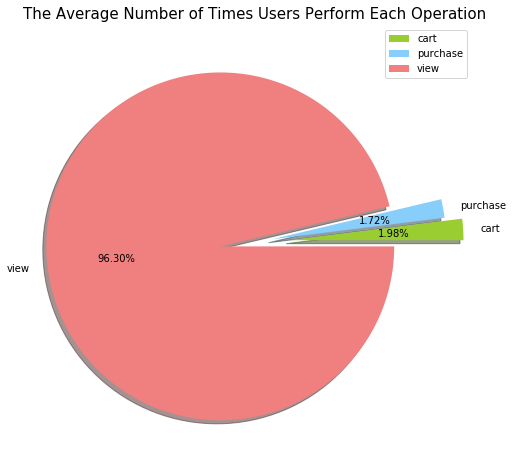

In [10]:
labels = ['cart', 'purchase', 'view']
size = df.groupby('event_type').event_type.count()/df.user_session.nunique()
colors = ['yellowgreen', 'lightskyblue','lightcoral']
explode = [0.2, 0.1, 0.2]
plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, colors = colors, explode = explode,\
labels = labels, shadow = True,  autopct = '%.2f%%') 
plt.title('The Average Number of Times Users Perform Each Operation', fontsize = 15)
plt.axis('off')
plt.legend()
plt.show()

##### 2.1.2 Q2

How many times, on average, a user views a product before adding it to the cart?

In [16]:
def view2cart(df):
    cart = df[df.event_type == 'cart'][['user_id', 'product_id', 'event_type', 'event_time']]
    view = df[df.event_type == 'view'][['user_id', 'product_id', 'event_type', 'event_time']]
    new_df = view.merge(cart, on=['user_id', 'product_id']) 
    new_df= new_df[new_df.event_time_x > new_df.event_time_y]
    return new_df.groupby(['user_id', 'product_id']).event_time_x.count().mean()

In [18]:
print('Answer = ' + str(view2cart(df)))

Answer = 3.9167974882260594


##### 2.1.3 Q3

What’s the probability that products added once to the cart are effectively bought?

In [224]:
et_count = df.groupby('event_type').event_type.count()

In [14]:
type(df.groupby('event_type').event_type.count())

pandas.core.series.Series

In [23]:
#probability that it will go to cart 
p_cart =  et_count['cart']/et_count['view']
#probability that it will go from cart to purchase 
p_purchase = et_count['purchase']/et_count['cart']
# probability it will be bought

In [107]:
print('Answer = ' + str(p_purchase))

Answer = 0.8695459325302886


##### 2.1.4 Q4 

What’s the average time an item stays in the cart before being removed?

I could not find attributes 'remove from cart'

##### 2.1.5 Q5 

How much time passes on average between the first view time and a purchase/addition to cart?

In [19]:
# took to much computation but I understand the logic here 

### 2.2 RQ2 What are the categories of the most trending products overall? For each month visualize this information through a plot showing the number of sold products per category.
#### 2.2.1 Q1
Plot the most visited subcategories

In [31]:
# added these parameters 'infer_datetime_format=True, utc=True' because otherwise the conversion to datetime
# format was too slow 
print('Changing to date format')  
df['event_time'] =  pd.to_datetime(df['event_time'], infer_datetime_format=True, utc=True) 
print('Leaving data until hours')
df['event_time'] = df['event_time'].dt.floor('h')
print('Ready')

Changing to date format
Leaving data until hours
Ready


In [144]:
# we can simply insert month
def trending_plot(df, event_type_str, month_int):
    df = df[pd.to_datetime(df['event_time']).dt.month == month_int]
    df[df.event_type == event_type_str]['category_code'].value_counts().head(10).plot.bar(figsize = (18, 7))
    # title='Top Category', \
    # xlabel='Names of Categories',\
    # ylabel='Number of Appearances')

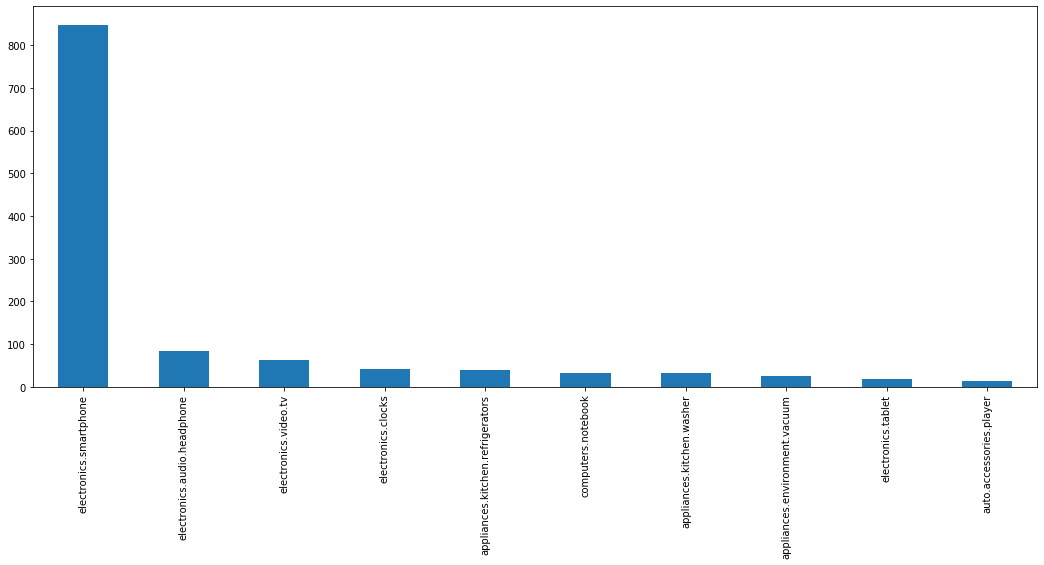

In [146]:
trending_plot(df, 'purchase', 11) # example

#### 2.2.2 Q2
What are the 10 most sold products per category?

In [74]:
def most_sold_brands_per_category(df, month_int, category_str):
    df = df[pd.to_datetime(df['event_time']).dt.month == month_int]
    df = df[df.event_type == 'purchase']
    df = df.groupby([df.category_code, df.brand], sort = True).brand.count().reset_index(name='count') \
                             .sort_values(['count'], ascending=False)
    df = df[df.category_code == category_str]
    return df.head(10)

In [78]:
# we can find any category just by referring to list of unique categories
# As in previous, we can insert month
most_sold_brands_per_category(df, 11, 'electronics.smartphone') 

,category_code,brand,count
150,electronics.smartphone,samsung,389
143,electronics.smartphone,apple,264
153,electronics.smartphone,xiaomi,93
144,electronics.smartphone,huawei,45
149,electronics.smartphone,oppo,35
152,electronics.smartphone,vivo,9
147,electronics.smartphone,meizu,6
146,electronics.smartphone,jinga,3
151,electronics.smartphone,tp-link,2
145,electronics.smartphone,inoi,1


### 2.3. [RQ3] For each category, what’s the brand whose prices are higher on average?
#### 2.3.1 Write a function that asks the user a category in input and returns a plot indicating the average price of the products sold by the brand


In [99]:
def sold_products_mean_price_plot(df,category_str):
    df = df[df.event_type == 'purchase']
    df = df[df.category_code == category_str]
    df = df.groupby([ df.brand]).price.mean().reset_index(name='mean') \
                             .sort_values(['mean'], ascending=False)
    df = df.set_index('brand')
    df['mean'].plot.bar(figsize = (18, 7))

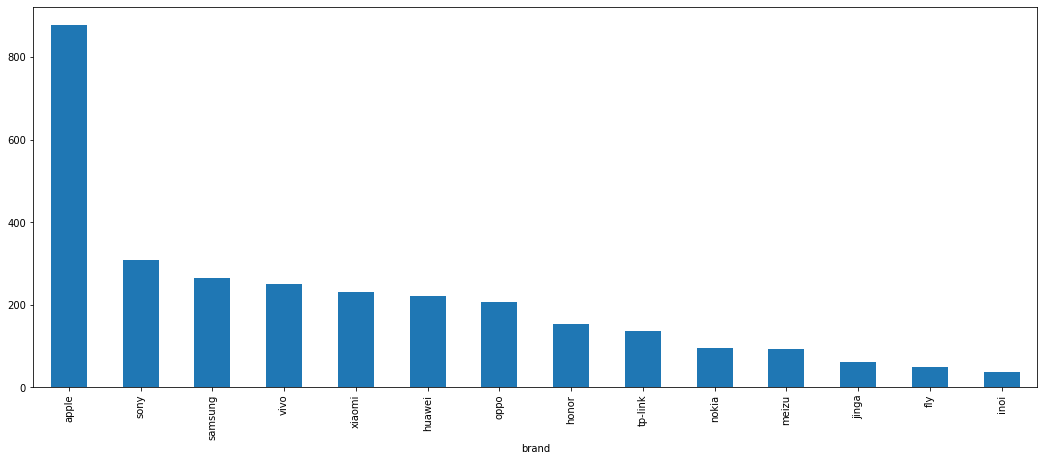

In [100]:
 sold_products_mean_price_plot(df,'electronics.smartphone')

#### 2.3.2 Find, for each category, the brand with the highest average price. Return all the results in ascending order by price.

In [113]:
# here we can input each category
def sold_products_highest_mean_price(df, category_str):
    df = df[df.event_type == 'purchase']
    df = df[df.category_code == category_str]
    df = df.groupby([ df.brand]).price.mean().reset_index(name='mean') \
                             .sort_values(['mean'], ascending=False)
    return df.iloc[0]['mean']

In [124]:
# list_highest_average_prices = []
# unique_categories = df['category_code'].value_counts().head().tolist()
# unique_categories = [x for x in unique_categories if str(x) != 'nan']
# for i in unique_categories:
#     a = sold_products_highest_mean_price(df, i)

Result

In [139]:
df.groupby([df.category_code, df.brand], sort = True).price.mean().reset_index(name='mean')\
.groupby(['category_code'], sort=False)['mean'].max().sort_values()

category_code
apparel.shorts                               4.558000
kids.fmcg.diapers                           19.670000
apparel.shoes.espadrilles                   22.650000
auto.accessories.anti_freeze                23.715000
apparel.scarf                               25.480000
accessories.umbrella                        25.710000
apparel.underwear                           25.740000
stationery.cartrige                         40.645000
apparel.shoes.step_ins                      43.760000
apparel.shoes.ballet_shoes                  43.990000
medicine.tools.tonometer                    49.816885
apparel.jeans                               50.197500
apparel.jacket                              50.430000
electronics.telephone                       50.660376
apparel.belt                                55.600000
appliances.kitchen.coffee_grinder           63.188571
accessories.wallet                          71.559500
apparel.shoes.sandals                       73.360000
apparel.tshirt

### 2.4 [RQ4] How much does each brand earn per month? Write a function that given the name of a brand in input returns, for each month, its profit.


In [157]:
summation_by_brand = df.groupby([df.category_code, df.brand], sort = True)\
.price.sum().sort_values(ascending= False).reset_index(name ='sum')
summation_by_brand.head()

,category_code,brand,sum
0,electronics.smartphone,apple,15469372.72
1,electronics.smartphone,samsung,5911870.59
2,electronics.smartphone,xiaomi,2389511.68
3,electronics.smartphone,huawei,1357985.89
4,electronics.video.tv,samsung,1128143.68


In [159]:
print('All brands amount to ' + str(summation_by_brand.brand.shape[0]) )

All brands amount to 2046


In [162]:
print('Unique brands amount to ' + str(summation_by_brand.brand.nunique()))

Unique brands amount to 1063


By running two above codes, we can understand that there might be brands with same names within each category.
Thus, in input, we will indicate both category and brand. 

In [166]:
def profit_brand_month(df, category_str, brand_str):
    df = df[df.event_type == 'purchase']
    df = df[df.category_code == category_str]
    df = df[df.brand == brand_str]
    df10 = df[pd.to_datetime(df['event_time']).dt.month == 10]
    df11 = df[pd.to_datetime(df['event_time']).dt.month == 11]
    df10 = df10.groupby([df10.brand]).price.sum()
    df11 = df11.groupby([df11.brand]).price.sum()
    return df10, df11

In [167]:
profit_brand_month(df, 'electronics.smartphone', 'apple')

(brand
 apple    259145.96
 Name: price, dtype: float64, brand
 apple    230650.79
 Name: price, dtype: float64)

 #### 2.4.1 Is the average price of products of different brands significantly different?

In [179]:
def mean_price_std(df):
    df = df.groupby([df.category_code, df.brand]).price.mean().reset_index(name='mean') \
                             .sort_values(['mean'], ascending=False)
    return df['mean'].std()

In [180]:
mean_price_std(df)
# on average, it is different by 286 points

286.1558247675313

#### 2.4.2 Using the function you just created, find the top 3 brands that have suffered the biggest losses in earnings between one month and the next, specifing bothe the loss percentage and the 2 months (e.g., brand_1 lost 20% between march and april).

In [195]:
def profit_difference_month(df):
    df = df[df.event_type == 'purchase']
    df10 = df[pd.to_datetime(df['event_time']).dt.month == 10]
    df11 = df[pd.to_datetime(df['event_time']).dt.month == 11]
    
    df10 = df10.groupby([df10.category_code, df10.brand], sort = True)\
    .price.sum().sort_values(ascending= False).reset_index(name ='March_sum')
    
    df11 = df11.groupby([df11.category_code, df11.brand], sort = True)\
    .price.sum().sort_values(ascending= False).reset_index(name ='November_sum')
    
    new_df = pd.merge(df10, df11,  how='left', left_on=['category_code', 'brand'], right_on = ['category_code', 'brand'])
    
    new_df['%d'] = new_df[['March_sum', 'November_sum']].apply(lambda row: (row.iloc[1]-row.iloc[0])/row.iloc[0]*100, axis=1)
    
    final_df = new_df.sort_values(by=['%d'])
    
    return final_df.head(3)
    

In [196]:
profit_difference_month(df)

,category_code,brand,March_sum,November_sum,%d
42,electronics.audio.headphone,samsung,515.24,36.15,-92.983852
38,electronics.clocks,xiaomi,644.30,139.98,-78.274096
30,electronics.video.tv,yasin,849.28,186.57,-78.031980


### 2.5 [RQ5] In what part of the day is your store most visited? 
#### Knowing which days of the week or even which hours of the day shoppers are likely to visit your online store and make a purchase may help you improve your strategies. Create a plot that for each day of the week show the hourly average of visitors your store has.

In [197]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
2,2019-10-01 00:00:00+00:00,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:00+00:00,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
7,2019-10-01 00:00:00+00:00,view,31500053,2053013558031024687,NaN,luminarc,41.16,550978835,6280d577-25c8-4147-99a7-abc6048498d6
18,2019-10-01 00:00:00+00:00,view,1306631,2053013558920217191,computers.notebook,hp,580.89,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
26,2019-10-01 00:00:00+00:00,view,34700031,2061717937420501730,NaN,NaN,151.87,539512263,f27a45f8-fb98-459a-96a6-45271f56a987


In [202]:
pwd

'/home/hduser/nfs/IliyasSpace/HW_Sapienza/Algorithmic Methods Of Data Mining And Laboratory (Aris)/HW2'

In [213]:
def visits_time(df):
    df = df[df.event_type == 'view']
    df['hour'] = df.event_time.dt.hour
    df['weekday'] = df.event_time.dt.weekday
    df = df.groupby([df.weekday, df.hour]).hour.count().reset_index(name='count') \
#                             .sort_values(['count'], ascending=False)
    return df    

In [222]:
# visits_time(df)

/home/hduser/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/hduser/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 0.98, 'Number of visits for every hour by each weekday')

<Figure size 432x288 with 0 Axes>

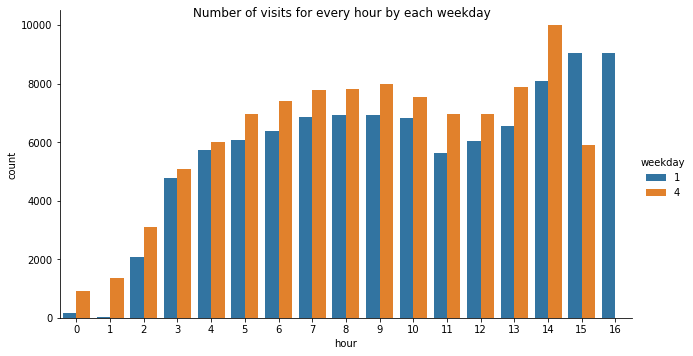

In [218]:
plt.subplots_adjust(top=0.9)
sns.catplot(x= "hour", y="count", hue="weekday", kind="bar", data=visits_time(df), height=5, aspect = 1.8)\
.fig.suptitle('Number of visits for every hour by each weekday')

/home/hduser/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/hduser/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 0.98, ' The hourly average of visitors for each weekday')

<Figure size 432x288 with 0 Axes>

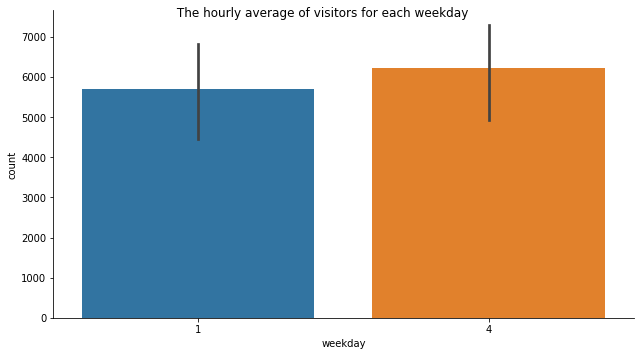

In [221]:
plt.subplots_adjust(top=0.9)
sns.catplot(x= "weekday", y="count", kind="bar", data=visits_time(df), height=5, aspect = 1.8)\
.fig.suptitle(' The hourly average of visitors for each weekday')

### 2.6. [RQ6] What's the conversion rate of your online store?

#### 2.6.1 Find the overall conversion rate of your store.

In [226]:
print('The overall conversion rate of my store = ' + str(et_count['purchase']/et_count['view']))

The overall conversion rate of my store = 0.018168696986791483


#### 2.6.2 Plot the number of purchases of each category. Show the conversion rate of each category in decreasing order.

In [240]:
def sold_categories_plot(df):
    df = df[df.event_type == 'purchase']
    df = df.groupby([ df.category_code]).category_code.count().head(20).reset_index(name='count').sort_values(['count'], ascending=False)
    df = df.set_index('category_code')
    df['count'].plot.bar(figsize = (18, 7))

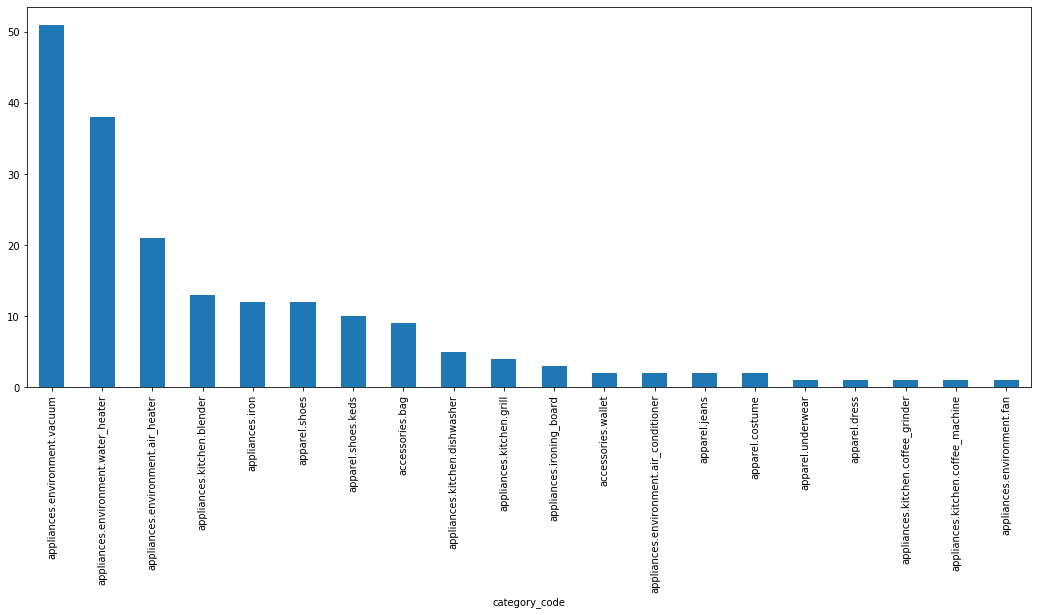

In [241]:
sold_categories_plot(df)

#### 2.6.3 Plot the number of purchases of each category. Show the conversion rate of each category in decreasing order.

In [245]:
def sold_categories_count(df, category_str):
    df = df[df.event_type == category_str]
    df = df.groupby([ df.category_code]).category_code\
        .count().reset_index(name='count')\
        .sort_values(['count'], ascending=False)
    return df

In [248]:
def converstion_rate_categories(df): 
    buy = sold_categories_count(df, 'purchase')
    view = sold_categories_count(df, 'view')
    df = pd.merge(buy, view,  how='left', \
                      left_on=['category_code'], right_on = ['category_code'])
    df['conversion_rate'] = df['count_x']/ df['count_y']
    df = df.sort_values(by=['conversion_rate'], ascending = False)
    return df

In [249]:
converstion_rate_categories(df) # second question

,category_code,count_x,count_y,conversion_rate
76,appliances.environment.fan,1,7,0.142857
63,computers.components.power_supply,2,27,0.074074
35,appliances.kitchen.toster,6,92,0.065217
60,stationery.cartrige,2,35,0.057143
55,electronics.camera.photo,3,53,0.056604
8,appliances.environment.water_heater,38,732,0.051913
57,medicine.tools.tonometer,3,63,0.047619
34,kids.fmcg.diapers,7,164,0.042683
54,appliances.ironing_board,3,89,0.033708
1,electronics.audio.headphone,169,5270,0.032068


### 2.7 [RQ7] Pareto Principle

In [262]:
def top_users_revenue(df):
    df = df[df.event_type == 'purchase']
    df = df.groupby([ df.user_id]).price.sum()\
    .reset_index(name='sum').sort_values(['sum'], ascending=False)
    top20 = math.floor(df.shape[0]*0.2)
    df = df.head(top20)
    return df['sum'].sum()

In [267]:
top20_users_revenue = top_users_revenue(df)

In [266]:
revenue80 = (df[df.event_type == 'purchase']['price'].sum()*0.8)

In [268]:
top20_users_revenue/revenue80

0.7886110708190989

It does not hold in this case but the values are close